# Анализ и прогнозирование временных рядов методами искусственного интеллекта

## **Практическая работа 1. Метрики и меры схожести между временными рядами.**

Смените рабочую директорию с помощью команды `chdir()`. Для этого передайте этой команде свой путь до каталога, в котором содержатся материалы первой практической работы. После выполнения этой команды все последующие операции с файлами и каталогами будут производиться относительно указанного каталога.

In [2]:
import os

import os

practice_dir_path = os.getcwd()

os.chdir(practice_dir_path)

print(practice_dir_path)

c:\Users\maxoh\Documents\2024-Ohezin-TimeSeriesCourse\practice\01 Basics


Выполните команды, которые автоматически перезагружают все импортированные модули при их изменении.

In [3]:
%load_ext autoreload
%autoreload 2

Импортируйте библиотеки и модули, необходимые для реализации практической работы 1.

In [4]:
!pip install sktime

Defaulting to user installation because normal site-packages is not writeable


In [1]:
import numpy as np
import random
from sktime.distances import euclidean_distance, dtw_distance, pairwise_distance
from sklearn.metrics import silhouette_score
import cv2
import imutils
import glob
import matplotlib.pyplot as plt
# from google.colab.patches import cv2_imshow

from modules.metrics import ED_distance, norm_ED_distance, DTW_distance
from modules.pairwise_distance import PairwiseDistance
from modules.clustering import TimeSeriesHierarchicalClustering
# from modules.classification import TimeSeriesKNN, calculate_accuracy
# from modules.image_converter import image2ts
from modules.utils import read_ts, z_normalize, sliding_window, random_walk
from modules.plots import plot_ts

## **Часть 1.** Функции расстояния: евклидова метрика и DTW мера. Матрица расстояний. Иерархическая кластеризация временных рядов.

### **Задача 1.**
Реализуйте самостоятельно функцию `ED_distance()` в модуле *metrics.py*, которая вычисляет евклидово расстояние между двумя временными рядами, имеющими одинаковую длину. В качестве входных данных передайте в функцию два синтетических временных ряда некоторой заданной вами длины. Для их генерации используйте функцию `random_walk()` из модуля *utils.py*,  реализующую модель случайных блужданий (Random Walk), или стандартный модуль *random*.

**Евклидово расстояние** между двумя временными рядами $T_1$ и $T_2$ длины $n$ вычисляется следующим образом:

\begin{equation}
    \text{ED}(T_1, T_2) = \sqrt{\sum_{i=1}^{n} ({t_{1}}_i-{t_{2}}_i)^2}.
\end{equation}

Проверьте реализацию функции, сравнив свои результаты с результатами функции [`euclidean_distance()`](https://www.sktime.net/en/latest/api_reference/auto_generated/sktime.distances.euclidean_distance.html) из библиотеки *sktime*, с помощью `test_distances()`.

In [6]:
def test_distances(dist1: float, dist2: float) -> None:
    """
    Check whether your distance function is implemented correctly

    Parameters
    ----------
    dist1 : distance between two time series calculated by sktime
    dist2 : distance between two time series calculated by your function
    """

    np.testing.assert_equal(round(dist1, 5), round(dist2, 5), 'Distances are not equal')

In [7]:
from sktime.distances import euclidean_distance as sktime_euclidean_distance


length = 100
T1 = random_walk(length)
T2 = random_walk(length)

dist1 = ED_distance(T1, T2)

dist2 = sktime_euclidean_distance(T1, T2)

test_distances(dist1, dist2)

### **Задача 2.**

Реализуйте самостоятельно функцию `DTW_distance()` в модуле *metrics.py*, которая вычисляет DTW расстояние между двумя временными рядами, имеющими одинаковую длину. Для вычисления расстояния между элементами временных рядов в DTW мере используйте евклидово расстояние. Временные ряды сгенерируйте аналогичным образом, как в задаче 1, или используйте уже созданные.

**Динамическая трансформация временной шкалы (Dynamic Time Warping, DTW)** – мера схожести между двумя временными рядами $T_1$ и $T_2$ длины $n$, вычисляемая следующим образом:

\begin{equation}
\text{DTW}(T_1, T_2) = d(n,n),
\\ d(i,j) = ({t_{1}}_i - {t_{2}}_j)^2 + \min \left\{
	\begin{array}{l l}
	d(i-1,j), \\
	d(i,j-1), \\
	d(i-1,j-1),
	\end{array}
	\right.
\\ d(0,0)=0, \quad d(i,0)=d(0,j)=\infty, \quad  1 \leqslant i,j \leqslant n.
\end{equation}

Сравните свои результаты с результатами функции [`dtw_distance()`](https://www.sktime.net/en/latest/api_reference/auto_generated/sktime.distances.dtw_distance.html) из библиотеки *sktime*. Для этого используйте `test_distances()` из задачи 1.

In [8]:
from sktime.distances import dtw_distance

dist1 = DTW_distance(T1, T2)
dist2 = dtw_distance(T1, T2)

test_distances(dist1, dist2)

### **Задача 3.**
Реализуйте нахождение матрицы расстояний между несколькими временными рядами.
Для этого заполните все методы c недостающим кодом в классе `PairwiseDistance` из модуля *pairwise_distance.py*. Для вычисления расстояний между рядами используйте ранее реализованные вами функции `ED_distance()` и `DTW_distance()` из модуля *metrics.py*.

Матрица расстояний между временными рядами определяется следующим образом. Пусть дано множество $S$, состоящее из $K$ временных рядов длины $n$: $\;S = \{T_1, T_2, ..., T_K\}, \; T_i \in \mathbb{R}^n$. Тогда под **матрицей расстояний** $D \in \mathbb{R}^{K \times K}$ понимается квадратная матрица, где каждый ее элемент $d(i,j)$ представляет собой расстояние между временными рядами $T_i$ и $T_j$ из множества $S$:
\begin{equation}
d(i,j) = dist(T_i, T_j), \quad T_i, T_j \in S, \quad 1 \leqslant i,j \leqslant K.
\end{equation}

Поскольку евклидова метрика и DTW мера удовлетворяют аксиоме симметричности (т.е. $dist(T_i, T_j)=dist(T_j, T_i)$), то матрица расстояний $D$ будет симметричной относительно главной диагонали. Для ускорения вычислений достаточно найти ее верхний треугольник, а нижний треугольник матрицы заполнить значениями верхнего треугольника следующим образом:
\begin{equation}
d(j,i) = d(i,j), \; где \; i < j.
\end{equation}

<center><img src="https://github.com/mzym/TimeSeriesCourse/blob/main/practice/01%20Basics/img/distance_matrix.png?raw=true" width="600"></center>

Сгенерируйте множество, состоящее из $K$ временных рядов некоторой длины $n$. Вычислите матрицы евклидовых и DTW расстояний между ними. Проверьте реализованные вами методы, сравнив свои результаты с результатами функции [`pairwise_distance()`](https://www.sktime.net/en/latest/api_reference/auto_generated/sktime.distances.pairwise_distance.html) из библиотеки *sktime*.

In [9]:
def test_matrices(matrix1 : np.ndarray, matrix2 : np.ndarray) -> None:
    """
    Check whether your matrix function is implemented correctly

    Parameters
    ----------
    matrix1 : distance matrix calculated by sktime
    matrix2 : distance matrix calculated by your function
    """

    np.testing.assert_equal(matrix1.round(5), matrix2.round(5), 'Matrices are not equal')

In [10]:
from sktime.distances import pairwise_distance

# Параметры
K = 5  # Количество временных рядов
n = 10  # Длина каждого временного ряда

np.random.seed(42)  
time_series_set = np.random.randn(K, n)

# Евклидово расстояние
euclidean_distance = PairwiseDistance(metric='euclidean')
euclidean_matrix = euclidean_distance.calculate(time_series_set)
# Евклидово расстояние с использованием sktime
sktime_euclidean_matrix = pairwise_distance(time_series_set, metric="euclidean")

test_matrices(euclidean_matrix, sktime_euclidean_matrix)


# DTW расстояние
dtw_distance = PairwiseDistance(metric='dtw')
dtw_matrix = dtw_distance.calculate(time_series_set)
# DTW расстояние с использованием sktime
sktime_dtw_matrix = pairwise_distance(time_series_set, metric="dtw")

test_matrices(dtw_matrix, sktime_dtw_matrix)


### **Задача 4.**
Далее рассмотрим задачу иерархической кластеризации временных рядов, где будет использоваться предвычисленная матрица расстояний.

Для этого сначала загрузите набор временных рядов CBF из файла *CBF_TRAIN.txt*, который располагается в директории *./datasets/part1*. Каждая строка данного файла содержит целевую переменную (класс: 0, 1 или 2) в первом столбце и временной ряд в остальных столбцах. Набор CBF является синтетическим и включает в себя 30 временных рядов,  каждый из которых принадлежит к одному из трех классов.

Выполните визуализацию по одному временному ряду из каждого класса. Для этого используйте функцию `plot_ts()` из модуля *plots.py*.

In [11]:
import numpy as np
import pandas as pd

# Загрузка данных из файла
url = './datasets/part1/CBF_TRAIN.txt'
data = pd.read_csv(url, header=None, delimiter='  ')

# Разделение данных на метки и временные ряды
labels = data[0].values
time_series = data.drop(0, axis=1).values

# Выбор по одному ряду из каждого класса
unique_labels = np.unique(labels)
selected_ts = []

for label in unique_labels:
    idx = np.where(labels == label)[0][0]
    selected_ts.append(time_series[idx])

selected_ts = np.array(selected_ts)

# Визуализация выбранных временных рядов
plot_ts(selected_ts, plot_title='Example Time Series from Each Class')


# В plots.py изменил fig.show(renderer="browser"), иначе выдавало ошибку 

C:\Users\maxoh\AppData\Local\Temp\ipykernel_3108\3057400340.py:6: ParserWarning:

Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.



Далее самостоятельно реализуйте класс `TimeSeriesHierarchicalClustering` из модуля *clustering.py*, который выполняет иерархическую кластеризацию временных рядов.

Перед тем как приступить к реализации, изучите скелет этого класса. Реализуйте метод `fit()`, выполняющий кластеризацию данных на основе предвычисленной матрицы расстояний, которая передается в данный метод. Поскольку реализовать иерархическую кластеризацию довольно сложно, используйте готовую реализацию [`AgglomerativeClustering`](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html) из *sklearn*.   

Выполните иерархическую кластеризацию загруженных временных рядов CBF для двух функций расстояния: евлидовой метрики и DTW меры.
Для этого сначала найдите матрицы расстояний между временными рядами, используя класс `PairwiseDistance`, и передайте каждую матрицу в метод `fit()` для кластеризации.
Далее выполните визуализацию результатов в виде дендрограмм с помощью метода `plot_dendrogram()`, передав исходный набор временных рядов и их метки.

c:\Users\maxoh\Documents\2024-Ohezin-TimeSeriesCourse\practice\01 Basics\modules\clustering.py:45: ClusterWarning:

The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix

c:\Users\maxoh\Documents\2024-Ohezin-TimeSeriesCourse\practice\01 Basics\modules\clustering.py:45: ClusterWarning:

The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix



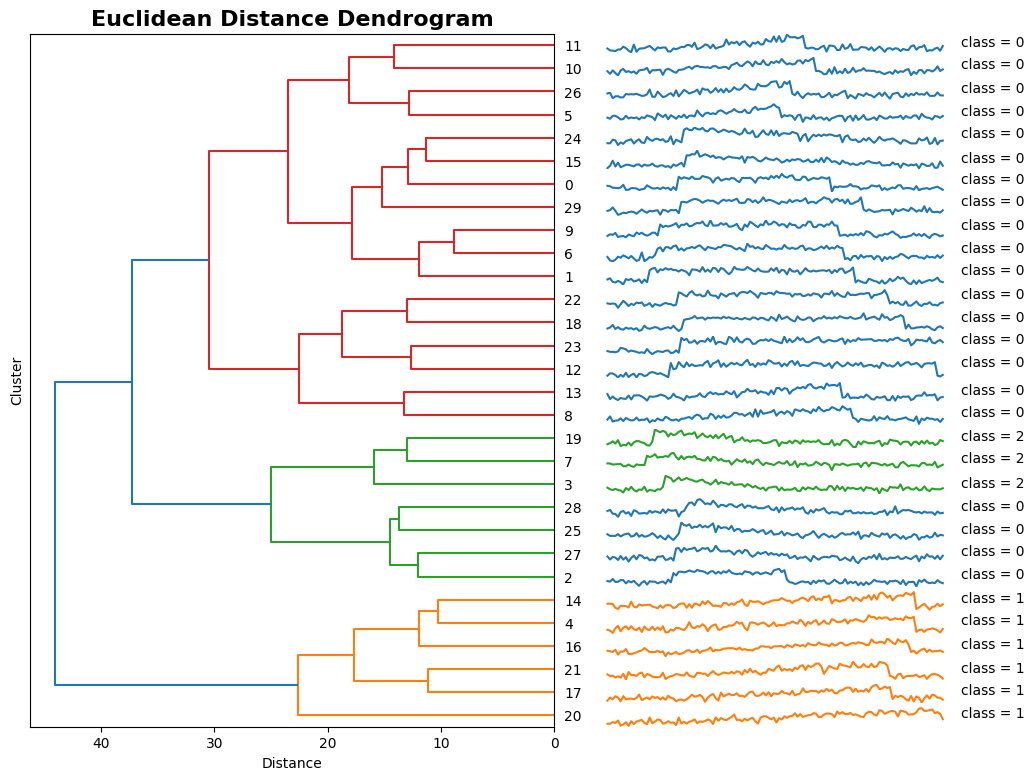

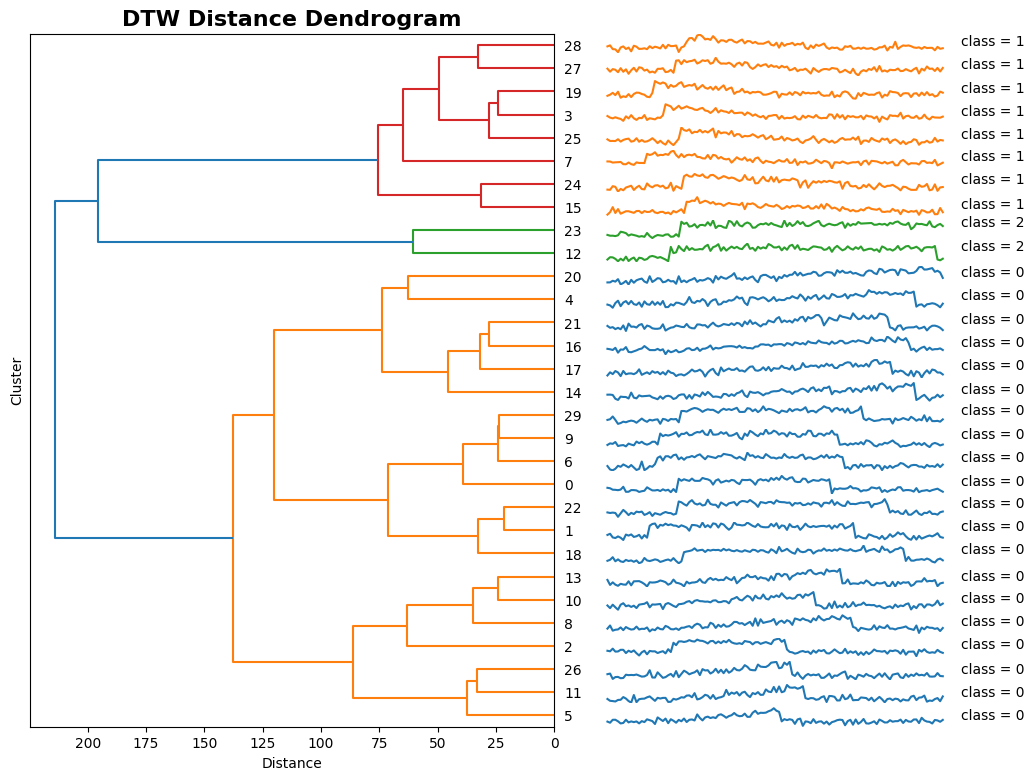

In [15]:


# Вычисление матрицы расстояний для евклидовой метрики
ed_distance_matrix = PairwiseDistance(metric='euclidean').calculate(time_series)

# Вычисление матрицы расстояний для DTW меры
dtw_distance_matrix = PairwiseDistance(metric='dtw').calculate(time_series)


# Кластеризация с использованием евклидовой метрики
ed_clustering = TimeSeriesHierarchicalClustering(n_clusters=3, method='complete')
ed_labels = ed_clustering.fit_predict(ed_distance_matrix)
ed_clustering.plot_dendrogram(pd.DataFrame(time_series), ed_labels, title='Euclidean Distance Dendrogram')

# Кластеризация с использованием DTW меры
dtw_clustering = TimeSeriesHierarchicalClustering(n_clusters=3, method='complete')
dtw_labels = dtw_clustering.fit_predict(dtw_distance_matrix)
dtw_clustering.plot_dendrogram(pd.DataFrame(time_series), dtw_labels, title='DTW Distance Dendrogram')

Сравните результаты иерархической кластеризации, полученные при двух различных функций расстояния, с помощью силуэтного коэффициента. Для этого используйте функцию [`silhouette_score()`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html) из библиотеки *sklearn*, передав в нее предвычисленную матрицу расстояний и предсказанные метки.

**Силуэтный коэффициент** – метрика, которая оценивает качество кластеризации на основе исходной выборки и результатов кластеризации без необходимости знания об истинных метках объектов.

Силуэтный коэффициент для выборки показывает, насколько среднее расстояние до объектов своего кластера отличается от среднего расстояния до объектов других кластеров. Пусть дана выборка $X$, состоящая из $N$ объектов. Предположим, что объекты этой выборки были разбиты на кластеры $c_1, ... c_K$, $c_i \in C$, с помощью некоторого алгоритма кластеризации. Тогда силуэтный коэффициент для выборки будет вычисляться следующим образом:

\begin{equation}
sil\_coef = \frac{1}{N} \sum_{c_k \in C} \sum_{x_i \in c_k} \frac{b(x_i, c_k) - a(x_i, c_k)}{\max(a(x_i, c_k), b(x_i, c_k))},
\end{equation}

где $a(x_i, c_k)$ – среднее расстояние от объекта $x_i \in c_k$ до других объектов из этого же кластера $c_k$; <br> $b(x_i, c_k)$  – среднее расстояние от объекта $x_i \in c_k$ до объектов из другого кластера $c_l$, $k \neq l$.

Силуэтный коэффициент принимает значения от  −1  до  1:
*   –1 означает, что кластеры плохие, размытые;
*   0 означает, что кластеры накладываются друг на друга;
*   1 означает, что кластеры плотные и хорошо отделены друг от друга.

Таким образом, чем ближе значение коэффициента к 1, тем лучше кластеризованы данные.

In [20]:
from sklearn.metrics import silhouette_score

# Вычисление силуэтного коэффициента для евклидовой метрики
ed_silhouette_score = silhouette_score(ed_distance_matrix, ed_labels, metric='precomputed')
print(f"Силуэтный коэффициент при Евклидовом расстоянии: \t{ed_silhouette_score}")

# Вычисление силуэтного коэффициента для DTW меры
dtw_silhouette_score = silhouette_score(dtw_distance_matrix, dtw_labels, metric='precomputed')
print(f"Силуэтный коэффициент при DTW расстоянии: \t\t{dtw_silhouette_score}")

Силуэтный коэффициент при Евклидовом расстоянии: 	0.1803917727906887
Силуэтный коэффициент при DTW расстоянии: 		0.3881450644470224


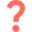
Проанализируйте полученные результаты кластеризации с помощью построенных дендрограмм и вычисленных силуэтных коэффициентов. Какая, на ваш взгляд, функция расстояния показала лучший результат и почему? Укажите, в каких случаях более предпочтительно использовать DTW меру, чем евклидову метрику.

Силуэтный коэффициент при использовании DTW меры значительно выше, чем при использовании евклидовой метрики. Это указывает на то, что кластеризация с использованием DTW меры более плотная и хорошо отделена, чем при использовании евклидовой метрики.

DTW мера показала лучший результат, так как силуэтный коэффициент для DTW меры значительно выше, чем для евклидовой метрики. Это указывает на то, что кластеры, полученные с использованием DTW меры, более плотные и хорошо отделены друг от друга.

*Евклидова метрика может не подходить для временных рядов, особенно если ряды имеют различную длину или форму, так как она не учитывает возможные сдвиги и растяжения во времени.*

## **Часть 2.** $Z$-нормализация временных рядов.

### **Задача 5.**
Реализуйте функцию вычисления нормализованного евклидова расстояния между временными рядами `norm_ED_distance()` в модуле *metrics.py* и проверьте правильность своей реализации, сравнив полученные результаты с результатами функции [`ed_distance()`](https://www.sktime.net/en/latest/api_reference/auto_generated/sktime.distances.euclidean_distance.html) из библиотеки *sktime*, в которую необходимо передать <u>нормализованные</u> временные ряды. Для нормализации временных рядов используйте функцию `z-normalize()` из *utils.py*.  Для проверки можно использовать синтетические временные ряды из первой части или заново их сгенерировать.

**Нормализованная евклидова метрика** между двумя временными рядами $T_1$ и $T_2$ длины $n$ вычисляется следующим образом:

\begin{equation}
	\text{ED}_{norm}(T_1, T_2) = \sqrt {\Big|\; 2n\left(1-\dfrac{<T_1, T_2> - \; n \; \cdotp \mu_{T_1} \; \cdotp \mu_{T_2}}{n \; \cdotp \sigma_{T_1} \; \cdotp \sigma_{T_2}}\right)\Big|},
\end{equation}

где $<T_1, T_2>$ – скалярное произведение временных рядов, $\mu_{T_1}$ и $\mu_{T_2}$, $\sigma_{T_1}$ и $\sigma_{T_2}$ – среднее арифметическое и стандартное отклонение временных рядов соответственно.

**Среднее арифметическое** $\mu_T$ и **стандартное отклонение** $\sigma_T$ временного ряда $T$ длины $n$ вычисляются по следующим формулам:

\begin{equation}
	\mu_{T} = \frac{1}{n}\sum\limits_{i=1}^{n} t_{i}, \\[1em]
	\sigma_{T} = \sqrt{\frac{1}{n}\sum\limits_{i=1}^{n} t_i^2-\mu_{T}^2}.
\end{equation}

In [27]:
from sktime.distances import euclidean_distance as sktime_ed_distance
from modules.utils import z_normalize

# Генерация синтетических временных рядов
ts1 = np.random.rand(100)
ts2 = np.random.rand(100)

# Нормализация временных рядов
ts1_norm = z_normalize(ts1)
ts2_norm = z_normalize(ts2)

# Вычисление нормализованного евклидова расстояния с использованием нашей функции
norm_ed_dist_custom = norm_ED_distance(ts1_norm, ts2_norm)

# Вычисление евклидова расстояния с использованием sktime
norm_ed_dist_sktime = sktime_ed_distance(ts1_norm, ts2_norm)

# Сравнение результатов
print(f"Custom Normalized: {norm_ed_dist_custom}")
print(f"sktime Normalized: {norm_ed_dist_sktime}")

Custom Normalized: 13.182693465713918
sktime Normalized: 13.182693465713918


### **Задача 6.**
Далее убедимся, что выполнение $z$-нормализации на этапе предобработки данных имеет важное значение и может повысить точность решаемой задачи.

В данном задании вы продолжите решать задачу иерархической кластеризации. В качестве данных будут использоваться два временных ряда из набора данных [BIDMC](https://physionet.org/content/chfdb/1.0.0/). Набор BIDMC состоит из записей ЭКГ-сигналов, снятых с 15 пациентов с сердечной недостаточностью тяжелой степени.  

Загрузите два временных ряда и визуализируйте их с помощью функции `plot_ts()` из модуля *plots.py*.

In [28]:
url1 = './datasets/part2/chf10.csv'
ts1 = read_ts(url1)

url2 = './datasets/part2/chf11.csv'
ts2 = read_ts(url2)

c:\Users\maxoh\Documents\2024-Ohezin-TimeSeriesCourse\practice\01 Basics\modules\utils.py:20: FutureWarning:

The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead

c:\Users\maxoh\Documents\2024-Ohezin-TimeSeriesCourse\practice\01 Basics\modules\utils.py:20: FutureWarning:

The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead



In [29]:
ts_set = np.concatenate((ts1, ts2), axis=1).T

In [30]:
plot_ts(ts_set)

Разделите каждый временной ряд на непересекающиеся подпоследовательности с помощью техники скользящего окна. Для этого используйте функцию `sliding_window()` из модуля *utils.py*, передав в нее временной ряд, заданную длину подпоследовательности и величину шага. В нашем случае, величина шага равна длине подпоследовательности.

In [31]:
m = 125
subs_set1 = sliding_window(ts_set[0], m, m-1)
subs_set2 = sliding_window(ts_set[1], m, m-1)

Сформируйте множество всех подпоследовательностей, извлеченных из двух временных рядов, и массив меток подпоследовательностей в соответствии с их принадлежностью к временному ряду.

In [32]:
subs_set = np.concatenate((subs_set1[0:15], subs_set2[0:15]))
labels = np.array([0]*subs_set1[0:15].shape[0] + [1]*subs_set2[0:15].shape[0])

Добавьте в класс `PairwiseDistance` из модуля *pairwise_distance.py* возможность вычисления нормализованной евклидовой метрики между временными рядами. Если матрица расстояний строится для нормализованных временных рядов на основе евклидовой метрики, то должна вызываться функция `norm_ED_distance()`. Для остальных метрик/мер схожести перед нахождением матрицы расстояний временные ряды должны подтвергаться $z$-нормализации с помощью функции `z_normalize()` из модуля *utils.py*.

Далее выполните иерархическую кластеризацию подпоследовательностей двух временных рядов с использованием предварительно построенных матриц расстояний на основе классической и нормализованной евклидовой метрики.

c:\Users\maxoh\Documents\2024-Ohezin-TimeSeriesCourse\practice\01 Basics\modules\clustering.py:45: ClusterWarning:

The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix



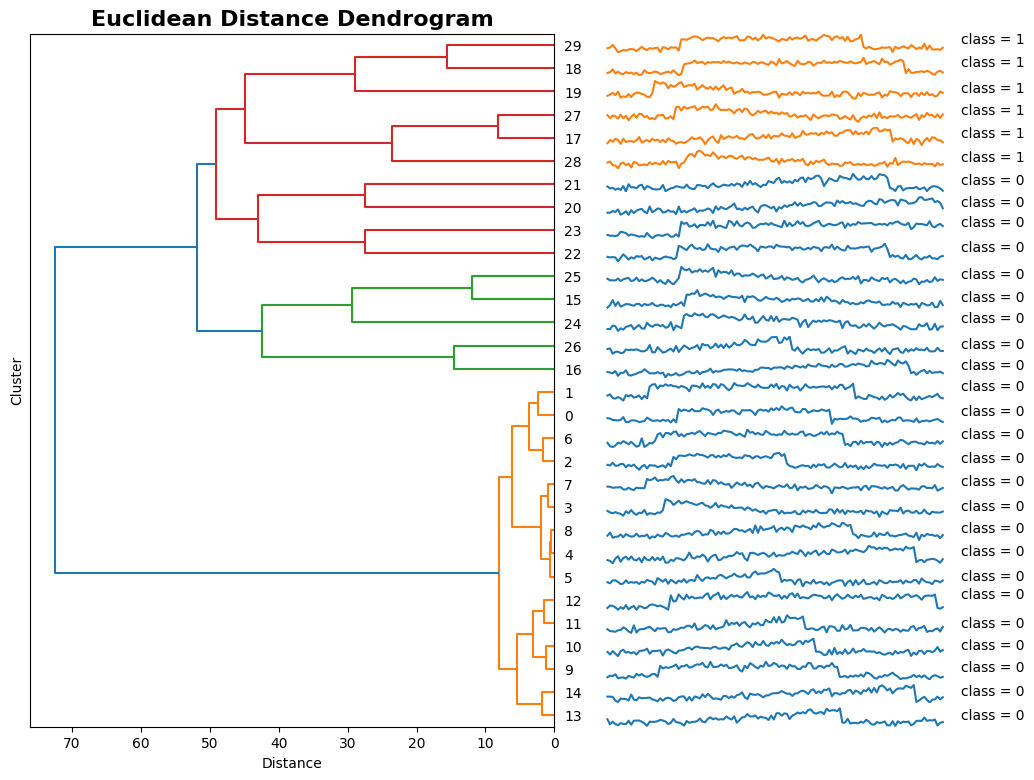

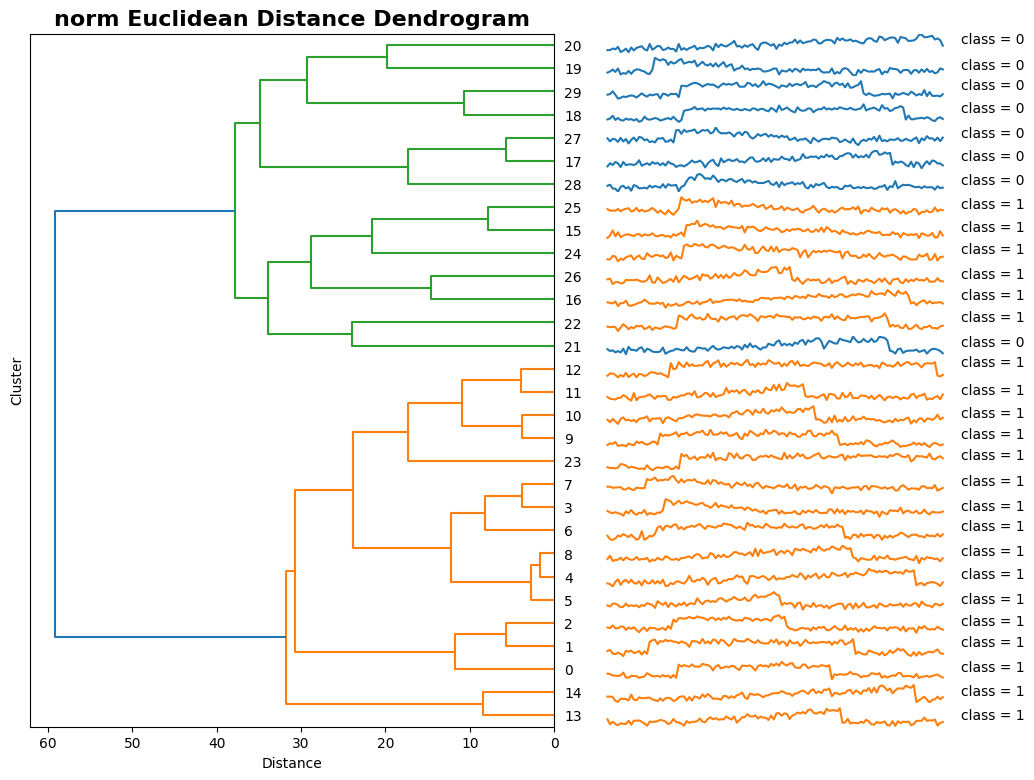

In [37]:
# Вычисление матрицы расстояний для евклидовой метрики
ed_distance_matrix = PairwiseDistance(metric='euclidean').calculate(subs_set)

# Вычисление матрицы расстояний для DTW меры
ned_distance_matrix = PairwiseDistance(metric='norm_euclidean').calculate(subs_set)


# Кластеризация с использованием евклидовой метрики
ed_clustering = TimeSeriesHierarchicalClustering(n_clusters=2, method='complete')
ed_labels = ed_clustering.fit_predict(ed_distance_matrix)
ed_clustering.plot_dendrogram(pd.DataFrame(time_series), ed_labels, title='Euclidean Distance Dendrogram')

# Кластеризация с использованием DTW меры
ned_clustering = TimeSeriesHierarchicalClustering(n_clusters=2, method='complete')
ned_labels = ned_clustering.fit_predict(ned_distance_matrix)
ned_clustering.plot_dendrogram(pd.DataFrame(time_series), ned_labels, title='norm Euclidean Distance Dendrogram')

Вычислите силуэтные коэффициенты для оценки качества кластеризации с нормализацией и без нее, как это было сделано в задаче 4 части 1.

In [40]:
# Вычисление матрицы расстояний для евклидовой метрики без нормализации
ed_distance_matrix_non_norm = PairwiseDistance(metric='euclidean', is_normalize=False).calculate(subs_set)

# Вычисление матрицы расстояний для евклидовой метрики с нормализацией
ed_distance_matrix_norm = PairwiseDistance(metric='euclidean', is_normalize=True).calculate(subs_set)

# Кластеризация с использованием евклидовой метрики без нормализации
ed_clustering_non_norm = TimeSeriesHierarchicalClustering(n_clusters=2, method='complete')
ed_labels_non_norm = ed_clustering_non_norm.fit_predict(ed_distance_matrix_non_norm)

# Кластеризация с использованием евклидовой метрики с нормализацией
ed_clustering_norm = TimeSeriesHierarchicalClustering(n_clusters=2, method='complete')
ed_labels_norm = ed_clustering_norm.fit_predict(ed_distance_matrix_norm)

# Вычисление силуэтного коэффициента для евклидовой метрики без нормализации
ed_silhouette_score_non_norm = silhouette_score(ed_distance_matrix_non_norm, ed_labels_non_norm, metric='precomputed')
print(f"non-normalized: \t{ed_silhouette_score_non_norm}")

# Вычисление силуэтного коэффициента для евклидовой метрики с нормализацией
ed_silhouette_score_norm = silhouette_score(ed_distance_matrix_norm, ed_labels_norm, metric='precomputed')
print(f"normalized: \t\t{ed_silhouette_score_norm}")

non-normalized: 	0.41829092209953717
normalized: 		0.32752186865268157


c:\Users\maxoh\Documents\2024-Ohezin-TimeSeriesCourse\practice\01 Basics\modules\clustering.py:45: ClusterWarning:

The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix

c:\Users\maxoh\Documents\2024-Ohezin-TimeSeriesCourse\practice\01 Basics\modules\clustering.py:45: ClusterWarning:

The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix



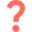
Сравните полученные результаты кластеризации с помощью построенных дендрограмм и вычисленных силуэтных коэффициентов. Позволила ли $z$-нормализации временных рядов повысить качество кластеризации?

Силуэтный коэффициент для евклидовой метрики без нормализации выше, чем с нормализацией. Это указывает на то, что кластеризация без нормализации дает более плотные и хорошо отделенные кластеры.

- **Нормализация не повысила качество кластеризации**:
  - Силуэтный коэффициент для евклидовой метрики без нормализации выше, чем с нормализацией.
  - Дендрограммы также могут показать, что кластеры без нормализации более четкие и хорошо отделены.

Когда нормализация может быть полезна:
- **Различная шкала данных**:
  - Если временные ряды имеют сильно различающиеся масштабы, нормализация может помочь привести их к одному масштабу, что может улучшить качество кластеризации.

- **Неравномерные распределения**:
  - Если данные имеют неравномерные распределения, нормализация может помочь сгладить эти различия и улучшить кластеризацию.

- **Смещение и масштабирование**:
  - Если временные ряды имеют смещение или масштабирование, нормализация может помочь устранить эти эффекты и улучшить кластеризацию.

## **Часть 3.** Классификация изображений, представленных в виде временных рядов.

### **Задача 7.**
В данном задании вам предстоит выполнить преобразование изображения, на котором находится некоторый объект, во временной ряд. Для этого вы реализуете один из существующих методов, предложенный в [статье Кеога и др](https://dl.acm.org/doi/10.5555/1182635.1164203).

Данный метод заключается в том, что сначала на изображении выполняется поиск контура $E = \{e_i\}_{i=1}^L$, где $e_i$ – точки контура, и центра масс объекта $O$. Затем берутся точки, расположенные на контуре объекта, следующим образом.

Рассмотрим луч $OP$ с началом в центре масс объекта $O$, направление которого совпадает с положительным направлением оси Ox (см. рисунок). Далее выполняется поворот против часовой стрелки луча $OP$ вокруг центра масс $O$ на некоторый заданный угол $α$, $1° \leqslant α \leqslant 360°$. Поворот луча будет осуществляться до тех пор, пока луч не пройдет полный оборот. Все точки $P = \{P_i\}_{i=1}^K$, $P_i \in E$, $K = \lfloor \frac{360°}{α} \rfloor$, образованные пересечением луча $OP$ с контуром $E$ во время поворота, будут являться искомыми.

На завершающем шаге метода вычисляются расстояния между центром масс объекта $O$ и найденными точками на контуре $P$. В качестве функции расстояния может быть использовано манхэттенское или евклидово расстояние. Полученные расстояния будут формировать временной ряд $T$ длины $K$:
\begin{equation}
T = \{t_i\}_{i=1}^K,\;где \; t_i = dist(O, P_i), \; P_i \in P.
\end{equation}


<center><img src="https://github.com/mzym/TimeSeriesCourse/blob/main/practice/01%20Basics/img/image2ts.png?raw=true" width="1000"></center>

Поскольку часть 3 предполагает работу с изображениями, то вы будете использовать для реализации некоторых частей кода библиотеку компьютерного зрения *cv2*. Для поиска всех необходимых функций рекомендуем воспользоваться [документацией библиотеки cv2](https://docs.opencv.org/4.x/d6/d00/tutorial_py_root.html).

Загрузите изображение *example.tif* из директории *./datasets/part3* и выполните его визуализацию с помощью соответствующих функций из библиотеки *cv2*.

In [1]:
import cv2
import numpy as np

# Загрузка изображения
image_path = './datasets/part3/example.tif'
img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

# Проверка, успешно ли загружено изображение
if img is None:
    print("Ошибка: Не удалось загрузить изображение.")
else:
    # Визуализация изображения
    cv2.imshow('Image', img)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

За конвертацию изображения во временной ряд с помощью описанного выше метода отвечает функция `image2ts()` из модуля *image_converter.py*. Прежде чем исходное изображение будет преобразовано во временной ряд, сначала оно должно пройти этап предварительной обработки. Предварительная обработка включает в себя следующие шаги:

<center><img src="https://github.com/mzym/TimeSeriesCourse/blob/main/practice/01%20Basics/img/image_preprocessing.png?raw=true" width="1000"></center>

Предобработка изображения в `image2ts()` осуществляется с помощью функции `_img_preprocess()`. Реализуйте в данной функции все представленные на диаграмме шаги предварительной обработки средствами библиотеки *cv2*. Промежуточные результаты должны совпадать с представленными на диаграмме.

Далее выполните конвертацию изображения во временной ряд, передав в функцию `image2ts()` следующие заданные вами аргументы:
*   исходное загруженное изображение;
*   шаг угла поворота;
*   параметр, определяющий нужно или нет визуализировать изображение с выделенными на нем контуром, центром масс и лучами, проведенными из центра.

Визуализируйте полученный временной ряд.


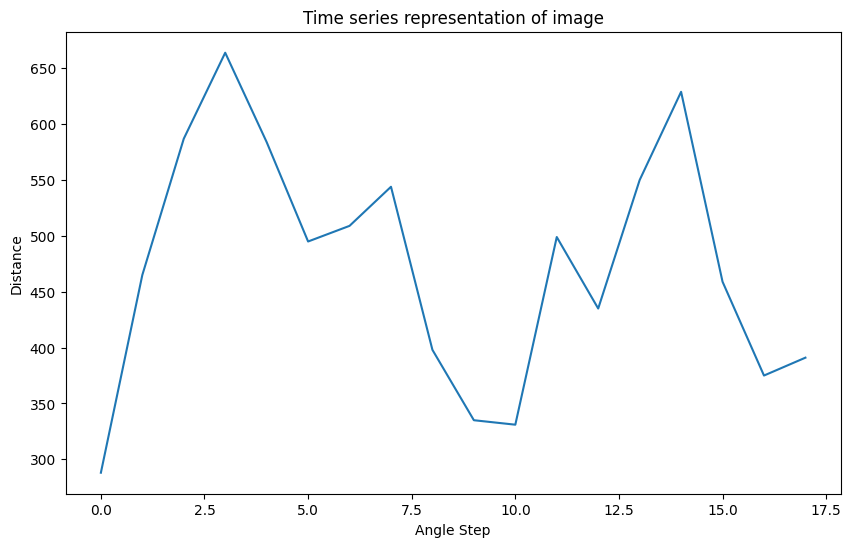

: 

In [2]:
from modules.image_converter import Image2TimeSeries

import matplotlib.pyplot as plt


angle_step = 20
visualize = True

# Создание экземпляра класса Image2TimeSeries
converter = Image2TimeSeries(angle_step=angle_step)

# Вызов метода convert для преобразования изображения во временной ряд
ts = converter.convert(img, is_visualize=visualize)

# Визуализация временного ряда
def plot_ts(ts_array, title):
    plt.figure(figsize=(10, 6))
    plt.plot(ts_array[0])
    plt.title(title)
    plt.xlabel("Angle Step")
    plt.ylabel("Distance")
    plt.show()

plot_ts(np.array([ts]), "Time series representation of image")

### **Задача 8.**

Выполните классификацию изображений, представленных в виде временных рядов, с помощью метода $k$ ближайших соседей (kNN).

**Метод $k$ ближайших соседей (kNN)** – алгоритм классификации, заключающийся в вычислении сходства между объектами на основе некоторой заданной метрики/меры схожести. Классифицируемый объект относится к тому классу, к которому принадлежит большинство из его $k$ соседей ($k$ ближайших к нему объектов из обучающей выборки).

Для классификации на основе алгоритма kNN необходимо выполнить следующие шаги:

1. Загрузить обучающую и тестовую выборки.

2. Задать параметр алгоритма $k$, где $k$ – количество ближайших соседей, $k \in \mathbb N^*$.

3. Для каждого объекта из тестовой выборки выполнить следующее:

    3.1. Вычислить расстояние до всех объектов из обучающей выборки на основе заданной метрики/меры схожести.
    
    3.2. Отсортировать в порядке возрастания найденные расстояния.

    3.3. Найти $k$ ближайших соседей, взяв первые $k$ минимальные расстояния из отсортированного массива расстояний.

    3.4. Назначить объекту из тестовой выборки наиболее часто встречающийся класс найденных ранее ближайших соседей.


Для этого задания вам предлагается набор данных, который содержит изображения листьев четырех различных пород деревьев: дуб, ольха, ива и липа. Набор данных состоит из обучающей и тестовой выборок, включающих по 15 и 10 изображений листьев на класс соответственно. Для составления этого набора данных изображения были взяты из [Swedish Leaf Dataset](https://www.cvl.isy.liu.se/en/research/datasets/swedish-leaf/).

Загрузите изображения из обучающей и тестовой выборок, а также их метки, используя `read_images()` и `read_ts()` соответственно.
Выполните визуализацию прецедентов выборки с помощью функции `plot_images()`.


In [2]:
def read_images(dir: str) -> list[np.ndarray]:
    """
    Load all images from a directory

    Parameters
    ----------
    dir: directory path

    Returns
    -------
    images: images from a directory
    """

    images = []
    for img_path in sorted(glob.glob(dir)):
        cv_img = cv2.imread(img_path)
        images.append(cv_img)

    return images

In [3]:
def plot_images(images: list[np.ndarray], labels: np.ndarray, class_names: list[str]) -> None:
    """
    Plot some images from dataset

    Parameters
    ----------
    images: dataset of images
    labels: labels of images
    class_names: class names of images
    """

    rows = 2
    columns = 4

    fig, axes = plt.subplots(nrows=rows, ncols=columns, figsize=(columns*2, rows*3))

    for num in range(1, rows*columns+1):
        fig.add_subplot(rows, columns, num)
        idx = num - 1
        plt.imshow(images[idx], aspect='auto')
        plt.title(f'{class_names[labels[idx]]}', fontsize=10)

    fig.tight_layout()

    for idx, ax in enumerate(axes.flat):
        ax.set_xticks([])
        ax.set_yticks([])

In [4]:
train_set_path = "./datasets/part3/train_set_leaves/*.tif"
test_set_path = "./datasets/part3/test_set_leaves/*.tif"

train_images = read_images(train_set_path)
test_images = read_images(test_set_path)

train_label_path = './datasets/part3/train_set_leaves/train_label.csv'
test_label_path = './datasets/part3/test_set_leaves/test_label.csv'

train_labels = read_ts(train_label_path)
train_labels = train_labels.reshape(-1).astype('int32')

test_labels = read_ts(test_label_path)
test_labels = test_labels.reshape(-1).astype('int32')

c:\Users\maxoh\Documents\2024-Ohezin-TimeSeriesCourse\practice\01 Basics\modules\utils.py:20: FutureWarning:

The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead

c:\Users\maxoh\Documents\2024-Ohezin-TimeSeriesCourse\practice\01 Basics\modules\utils.py:20: FutureWarning:

The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead



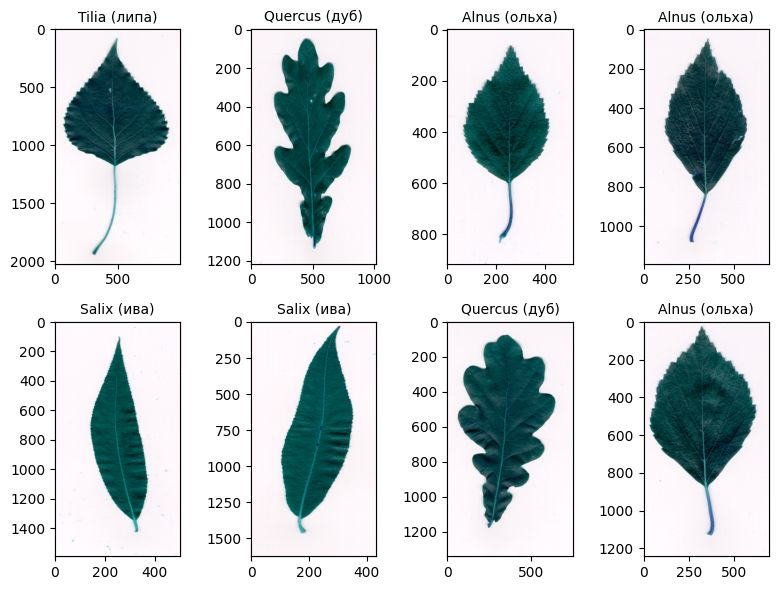

In [5]:
class_names = ['Quercus (дуб)', 'Alnus (ольха)', 'Salix (ива)', 'Tilia (липа)']
plot_images(train_images, train_labels, class_names)

Выполните преобразование изображений обучающей и тестовой выборок во временные ряды с помощью функции `image2ts()`.  

In [6]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from modules.image_converter import Image2TimeSeries

# Параметры для функции image2ts
angle_step = 20
visualize = False

# Создание экземпляра класса Image2TimeSeries
converter = Image2TimeSeries(angle_step=angle_step)

# Преобразование изображений обучающей выборки во временные ряды
train_ts = [converter.convert(img, is_visualize=visualize) for img in train_images]

# Преобразование изображений тестовой выборки во временные ряды
test_ts = [converter.convert(img, is_visualize=visualize) for img in test_images]

(2021, 996)
(1217, 1021)
(915, 515)
(1192, 698)
(1592, 502)
(1624, 435)
(1341, 753)
(1242, 691)
(1692, 515)
(1918, 1307)
(1368, 683)
(953, 527)
(1367, 389)
(1943, 1042)
(1380, 746)
(1492, 364)
(1946, 923)
(1003, 666)
(1921, 507)
(727, 515)
(1593, 867)
(1793, 490)
(1504, 980)
(1642, 942)
(1806, 465)
(1767, 980)
(1003, 603)
(1567, 464)
(1680, 553)
(1191, 753)
(1028, 553)
(1241, 779)
(1257, 733)
(1544, 784)
(1909, 569)
(1356, 963)
(903, 452)
(1730, 489)
(1266, 691)
(1028, 666)
(1483, 872)
(1429, 842)
(1758, 558)
(1015, 577)
(1346, 821)
(1956, 1256)
(1104, 616)
(1655, 866)
(1868, 477)
(2056, 1105)
(1434, 758)
(1304, 804)
(1542, 930)
(928, 553)
(1517, 879)
(2094, 540)
(2194, 1131)
(1053, 565)
(1003, 528)
(1971, 998)
(1129, 641)
(1870, 1033)
(1856, 490)
(991, 578)
(1316, 729)
(1404, 917)
(1429, 364)
(1520, 909)
(1471, 822)
(1078, 666)
(1016, 603)
(1180, 746)
(1416, 804)
(1604, 591)
(1768, 1118)
(1981, 1130)
(902, 553)
(927, 477)
(1192, 813)
(2018, 478)
(1742, 502)
(1567, 1030)
(902, 503)
(14

Для классификации временных рядов методом $k$ ближайших соседей вам необходимо использовать класс `TimeSeriesKNN` из модуля *classification.py*.
Реализуйте метод `fit()` в классе `TimeSeriesKNN`, который выполняет поиск для каждого элемента из тестовой выборки $k$ ближайших соседей и назначает им тот класс, который является часто встречающимся среди классов ближайших соседей. В качестве параметров в метод `fit()` передается тестовая выборка. Вычислите точность классификации по метрике accuracy с помощью функции `calculate_accurary()` из модуля *classification.py*.

In [7]:
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from modules.classification import TimeSeriesKNN, calculate_accuracy

# Параметры для kNN
n_neighbors = 6
metric = 'euclidean'
metric_params = {'normalize': True}

# Создание экземпляра класса TimeSeriesKNN
knn_classifier = TimeSeriesKNN(n_neighbors=n_neighbors, metric=metric, metric_params=metric_params)

# Обучение модели на обучающей выборке
knn_classifier.fit(train_ts, train_labels)

# Предсказание классов для тестовой выборки
predicted_labels = knn_classifier.predict(test_ts)

# Вычисление точности классификации
accuracy = calculate_accuracy(test_labels, predicted_labels)
print(f'Accuracy (Euclidean): {accuracy * 100:.2f}%')

Accuracy (Euclidean): 90.00%


In [8]:
# Изменение метрики на DTW
metric = 'dtw'
metric_params = {'normalize': True}

# Создание нового экземпляра класса TimeSeriesKNN с новой метрикой
knn_classifier_dtw = TimeSeriesKNN(n_neighbors=n_neighbors, metric=metric, metric_params=metric_params)

# Обучение модели на обучающей выборке с новой метрикой
knn_classifier_dtw.fit(train_ts, train_labels)

# Предсказание классов для тестовой выборки с новой метрикой
predicted_labels_dtw = knn_classifier_dtw.predict(test_ts)

# Вычисление точности классификации с новой метрикой
accuracy_dtw = calculate_accuracy(test_labels, predicted_labels_dtw)
print(f'Accuracy (DTW): {accuracy_dtw * 100:.2f}%')

Accuracy (DTW): 85.00%


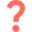
Проанализируйте результаты и сделайте выводы.


- **Евклидова метрика** показала более высокую точность (90%) по сравнению с DTW (85%). Это может указывать на то, что для данной задачи классификации изображений листьев, евклидова метрика более эффективна.
- **DTW** обычно используется для сравнения временных рядов, которые могут иметь различную длину или временные сдвиги. Однако, в данном случае, если все временные ряды имеют одинаковую длину и нет значительных временных сдвигов, евклидова метрика может быть более подходящей.

### Выводы:
- **Евклидова метрика** является более эффективной для данной задачи классификации изображений листьев, так как она показала более высокую точность и требует меньше вычислительных ресурсов.
- **DTW** может быть полезной в случаях, когда временные ряды имеют сложные структуры или значительные временные сдвиги, но в данном случае евклидова метрика оказалась более подходящей.

Для дальнейшего улучшения точности классификации можно попробовать следующие подходы:
  - Попробовать различные значения параметра `k` (количество ближайших соседей).
  - Попробовать другие метрики, такие как манхэттенское расстояние или косинусное сходство.
  - Попробовать различные методы предварительной обработки изображений, такие как различные типы фильтрации или изменение пороговых значений.
  - Попробовать другие алгоритмы классификации, такие как SVM, Random Forest.
